**Group H**

•	Saurabh Laltaprasad Gangwar

•	Brayan Leonardo Gil Guevara

•	Rohit Kumar

•	Marzieh Mohammadi Kokaneh

•	Eduardo Roberto Williams Cascante

**Notebook name:** BDM-3035_04_training.ipynb

**Description:** This notebook builds and trains the model

**Version:**

Python 3.11.3

pandas 2.0.3

numpy 1.26.4

matplotlib 3.7.1

tensorflow 2.16.1

In [1]:
%pip install labelme tensorflow tensorflow-gpu opencv-python albumentations
%pip install --upgrade tensorflow

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Eduardo\AppData\Local\Temp\pip-install-2tj3h7kb\tensorflow-gpu_f8662a51208f4501baef7ed5cb81b3ea\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not bu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


In [1]:
import pandas as pd
import numpy  as np
import os
import cv2
import json
import datetime
from matplotlib import pyplot as plt

# Importing layers and base network
import tensorflow as tf
from tensorflow.keras.models       import load_model, Model
from tensorflow.keras.layers       import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks    import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics      import SparseCategoricalAccuracy

In [2]:
# defining paths
diraug_train_img = "data_aug/train/images/"
diraug_train_lab = "data_aug/train/labels/"
diraug_test_img = "data_aug/test/images/"
diraug_test_lab = "data_aug/test/labels/"
diraug_valid_img = "data_aug/valid/images/"
diraug_valid_lab = "data_aug/valid/labels/"

In [3]:
# defining load_image function

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
# defining label loading function

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
         label = json.load(f)
         
    return [label['class']], label['bbox']

In [5]:
# load train augmented images to tensorflow dataset
train_images = tf.data.Dataset.list_files(diraug_train_img + '*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
# load test augmented images to tensorflow dataset
test_images = tf.data.Dataset.list_files(diraug_test_img + '*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
# load valid augmented images to tensorflow dataset
val_images = tf.data.Dataset.list_files(diraug_valid_img + '*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [8]:
# load train labels to Tensorflow Dataset
train_labels = tf.data.Dataset.list_files(diraug_train_lab + '*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [9]:
# load test labels to Tensorflow Dataset
test_labels = tf.data.Dataset.list_files(diraug_test_lab + '*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
# load valid labels to Tensorflow Dataset
val_labels = tf.data.Dataset.list_files(diraug_valid_lab + '*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
# check partition lengths
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(20000, 20000, 4000, 4000, 4000, 4000)

In [12]:
# creating final train dataset by conbining labels and images samples
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [13]:
# creating final test dataset by conbining labels and images samples
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [14]:
# creating final validation dataset by conbining labels and images samples
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [15]:
# verifying train dataset
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.3096 , 0.09955, 0.9414 , 0.876  ],
        [0.2947 , 0.09955, 0.737  , 0.7466 ],
        [0.231  , 0.471  , 0.672  , 0.9316 ],
        [0.1649 , 0.1111 , 0.7056 , 0.6772 ],
        [0.0932 , 0.1678 , 0.643  , 0.8193 ],
        [0.3223 , 0.3079 , 0.8027 , 0.896  ],
        [0.1453 , 0.337  , 0.6313 , 0.848  ],
        [0.143  , 0.4028 , 0.6304 , 0.869  ]], dtype=float16))

In [16]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [17]:
# 7.3 view images and annotations
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


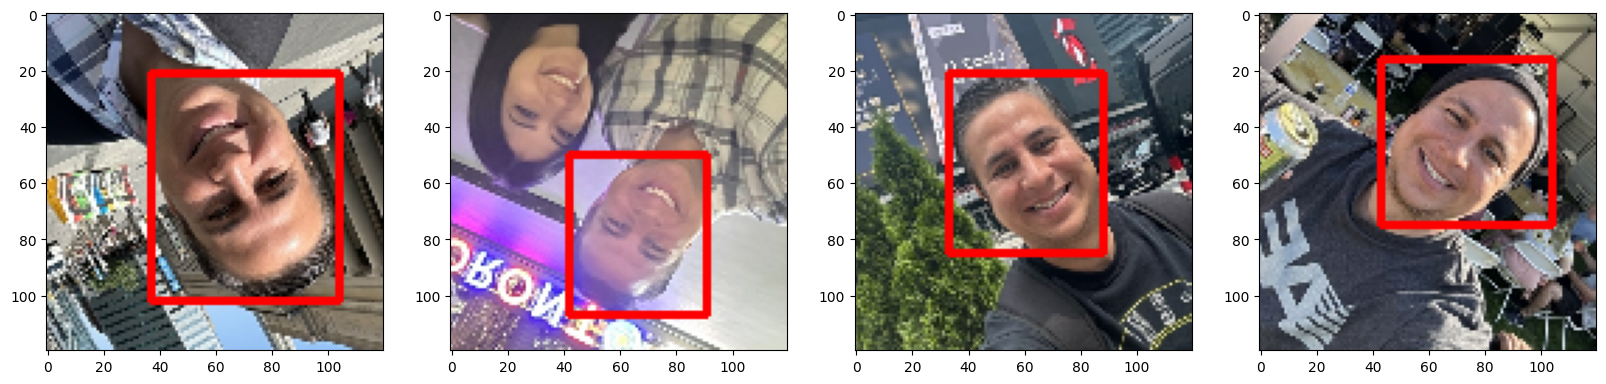

In [19]:
# drawing a sample
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coord = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coord[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coord[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
     
    #ax[idx].set_title(str(res[1][2][idx]))
    ax[idx].imshow(sample_image)

In [55]:
# 8. Building a deep learning using the functional API
# 8.2 Download VGG16
vgg = VGG16(include_top=False)

In [56]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Build instance of Network 
def build_model():
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(2, activation='softmax')(class1)
    
    # regression model / bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    
    return facetracker

In [58]:
# 8.4 test out Neural Network
facetracker = build_model()

In [59]:
facetracker.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │      4,098 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      8,196 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,828,230 (64.19 MB)

 Trainable params: 16,828,230 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
X, y = train.as_numpy_iterator().next()

In [61]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


In [62]:
classes, coords

(array([[0.3301903 , 0.6698097 ],
        [0.35257173, 0.6474283 ],
        [0.34314665, 0.6568534 ],
        [0.38754484, 0.6124551 ],
        [0.27740195, 0.722598  ],
        [0.26263806, 0.7373619 ],
        [0.33944863, 0.6605513 ],
        [0.35708013, 0.6429198 ]], dtype=float32),
 array([[0.31895763, 0.566384  , 0.48151568, 0.44801223],
        [0.36120185, 0.50661004, 0.5514204 , 0.3468755 ],
        [0.3921508 , 0.43538558, 0.5548128 , 0.5003673 ],
        [0.28849134, 0.58775914, 0.4979484 , 0.48880762],
        [0.28159252, 0.5294324 , 0.50925016, 0.37725505],
        [0.31683365, 0.46084103, 0.5813684 , 0.47118813],
        [0.3819255 , 0.40932155, 0.51085675, 0.52568066],
        [0.2968501 , 0.50436497, 0.547399  , 0.4847622 ]], dtype=float32))

In [63]:
num_epochs = 10
batches_per_epoch = len(train)
lr_decay = (1. / 0.75 - 1) / batches_per_epoch

In [64]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, weight_decay = lr_decay)

In [65]:
# Creating localization loss and classification loss

def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    return delta_coord + delta_size

In [66]:
classloss = tf.keras.losses.SparseCategoricalCrossentropy()
regressloss = localization_loss

In [67]:
# Testing out loss metrics
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.630512>

In [68]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1122003>

In [69]:
class FaceTracker(Model):
      def __init__(self, eyetracker, **kwargs):
          super().__init__(**kwargs)
          self.model = eyetracker
          
      def compile(self, opt, classloss, localizationloss, **kwargs):
          super().compile(**kwargs)
          self.closs = classloss
          self.lloss = localizationloss
          self.opt = opt
          self.accuracy_metric = SparseCategoricalAccuracy()
          
      @tf.function  # Decorate train_step with @tf.function
      def train_step(self, batch, **kwargs):
          X, y = batch          
          
          with tf.GradientTape() as tape:
               try:
                  classes, coords = self.model(X, training=True)                  
                                                   
                  # Ensure y[0] has a defined rank (handle potential reshaping)
                  y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1) if needed
                  
                  # Check your data format and reshape accordingly
                  # Ensure classes has a defined rank (check model output shape)
                  # ... (reshape classes if necessary based on your model's output)
                  
                  batch_classloss = self.closs(y_0, classes)
                  batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
                  total_loss = batch_localizationloss + 0.5 * batch_classloss
                  
               except tf.errors.InvalidArgumentError as e:
                  # Handle the case where y[0] might have a batch size of zero (optional)
                  if 'Input tensors must be of size at least 1' in str(e):
                     return {"total_loss": tf.constant(0.0)}  # Dummy loss (optional)
                  else:
                     raise e  # Re-raise other errors
                             
          grad = tape.gradient(total_loss, self.model.trainable_variables)
          self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
               
          # Updating metrics configured in compile()
          train_acc = 0
          
          for metric in self.metrics:
              metric.reset_state()
               
              if metric.name == "sparse_categorical_accuracy":
                 metric.update_state(y_true        = y_0,
                                     y_pred        = classes,
                                     sample_weight = None)
                 train_acc = metric.result()
                   
          return {"total_loss"  : total_loss,
                  "class_loss"  : batch_classloss,
                  "regress_loss": batch_localizationloss,
                  "accuracy"    : train_acc}
          
      def test_step(self, batch, **kwargs):
          X, y = batch
          classes, coords = self.model(X, training=False)
            
          # Ensure y[0] has a defined rank (handle potential reshaping)
          y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1) if needed
          # Check your data format and reshape accordingly
          # Ensure classes has a defined rank (check model output shape)
          # ... (reshape classes if necessary based on your model's output)
          batch_classloss = self.closs(y_0, classes)
          batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
          total_loss = batch_localizationloss + 0.5 * batch_classloss
          
          # Updating metrics configured in compile()
          valid_acc = 0
          
          for metric in self.metrics:
              metric.reset_state()
               
              if metric.name == "sparse_categorical_accuracy":
                 metric.update_state(y_true        = y_0,
                                     y_pred        = classes,
                                     sample_weight = None)
                 valid_acc = metric.result()
                    
          return {"total_loss"   : total_loss,
                  "class_loss"   : batch_classloss,
                  "regress_loss" : batch_localizationloss,
                  "accuracy"     : valid_acc}
                  
      def call(self, X, **kwargs):
          return self.model(X, **kwargs)

In [70]:
model = FaceTracker(facetracker)

In [71]:
model.compile(opt, classloss, regressloss)

In [81]:
# defining log folder
logdir= "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [83]:
# defining callbacks

tensorboard_callback = TensorBoard(log_dir = logdir)

early_stopping = EarlyStopping(monitor   = 'val_total_loss',
                               mode      = 'min',
                               patience  = 3,
                               min_delta = 0.01,
                               verbose   = 1)

model_checkpoint = ModelCheckpoint(filepath       = "facetracker_checkpoint.keras",
                                   monitor        = 'val_total_loss',
                                   mode           = 'min',
                                   save_best_only = True,
                                   verbose        = 1)

In [84]:
hist = model.fit(train,
                 epochs          = num_epochs,
                 validation_data = val,
                 callbacks       = [tensorboard_callback,
                                    early_stopping,
                                    model_checkpoint])

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9937 - class_loss: 0.0183 - regress_loss: 0.0450 - total_loss: 0.0542
Epoch 1: val_total_loss improved from inf to 0.08439, saving model to facetracker_checkpoint.keras


c:\Users\Eduardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4260s 2s/step - accuracy: 0.9937 - class_loss: 0.0183 - regress_loss: 0.0450 - total_loss: 0.0541 - val_accuracy: 1.0000 - val_class_loss: 0.0415 - val_regress_loss: 0.0637 - val_total_loss: 0.0844
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9973 - class_loss: 0.0109 - regress_loss: 0.0144 - total_loss: 0.0198
Epoch 2: val_total_loss improved from 0.08439 to 0.07771, saving model to facetracker_checkpoint.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3643s 1s/step - accuracy: 0.9973 - class_loss: 0.0109 - regress_loss: 0.0144 - total_loss: 0.0198 - val_accuracy: 1.0000 - val_class_loss: 0.0995 - val_regress_loss: 0.0279 - val_total_loss: 0.0777
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - class_loss: 1.8255e-04 - regress_loss: 0.0035 - total_loss: 0.0036
Epoch 3: val_total_loss improved from 0.07771 to 0.04293, saving model to facetracker_checkpoint.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3623s 1s/step - accuracy: 1

In [85]:
# 10.3 Plot Performance
hist.history

{'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'class_loss': [5.0064223614754155e-05,
  0.0010041052009910345,
  0.00019271498604211956,
  5.826317647006363e-06,
  0.00016797881107777357,
  4.798143891093787e-06],
 'regress_loss': [0.002547863405197859,
  0.020569996908307076,
  0.0013339805882424116,
  0.0024181518238037825,
  0.0028441783506423235,
  0.0012898866552859545],
 'total_loss': [0.0025728954933583736,
  0.02107204869389534,
  0.0014303381321951747,
  0.0024210650008171797,
  0.002928167814388871,
  0.001292285742238164],
 'val_accuracy': [1.0, 1.0, 1.0, 0.875, 1.0, 1.0],
 'val_class_loss': [0.04147018864750862,
  0.09952359646558762,
  0.010079599916934967,
  0.25744879245758057,
  0.00013002706691622734,
  0.0008965162560343742],
 'val_regress_loss': [0.06365359574556351,
  0.027946587651968002,
  0.037889596074819565,
  0.04400724172592163,
  0.11103847622871399,
  0.03616837412118912],
 'val_total_loss': [0.08438868820667267,
  0.07770838588476181,
  0.04292939603328705,

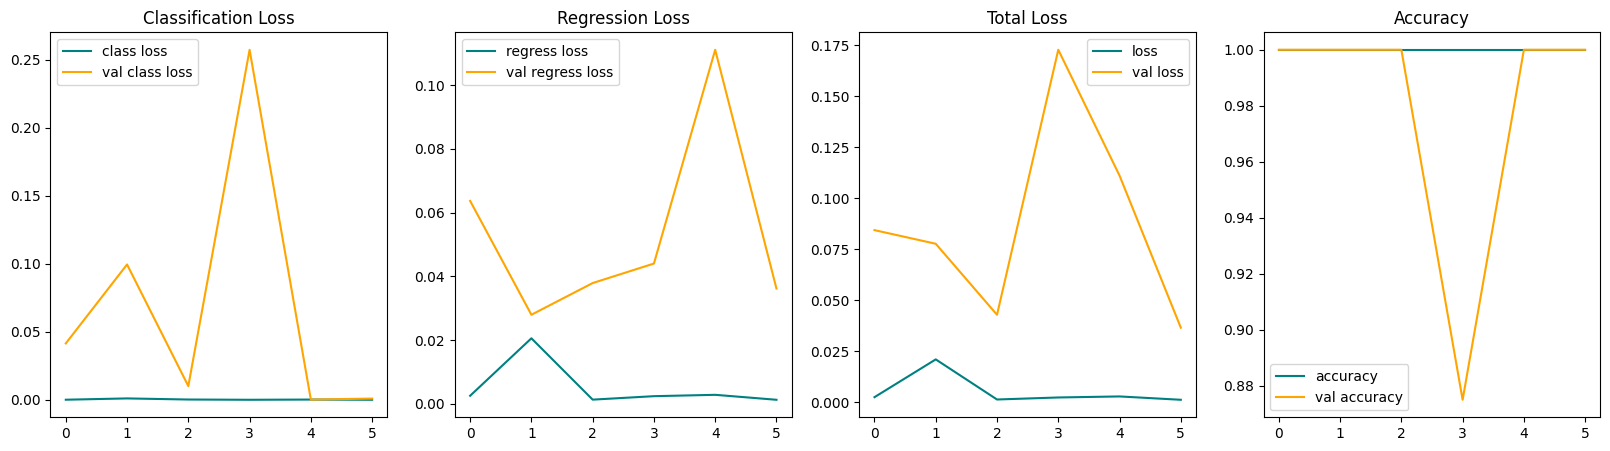

In [86]:
fig, ax = plt.subplots(ncols=4, figsize=(20,5))

ax[0].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[0].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[0].title.set_text('Classification Loss')
ax[0].legend()

ax[1].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[1].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['total_loss'], color='teal', label='loss')
ax[2].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[2].title.set_text('Total Loss')
ax[2].legend()

ax[3].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[3].plot(hist.history['val_accuracy'], color='orange', label='val accuracy')
ax[3].title.set_text('Accuracy')
ax[3].legend()

plt.show()

In [87]:
# restoring the best weights gotten in training
model.load_weights('facetracker_checkpoint.keras')

In [393]:
# Making predictions on Test dataset
test_data = test.as_numpy_iterator()

In [394]:
test_sample = test_data.next()

In [396]:
# evaluating the model
test_acc, test_class_loss, test_regress_loss, test_total_loss = model.evaluate(test_sample[0], test_sample[1], verbose = 2)

print (f'Accuracy     ==> {test_acc:.2f}')
print (f'Class loss   ==> {test_class_loss:.2f}')
print (f'Regress loss ==> {test_regress_loss:.2f}')
print (f'Total loss   ==> {test_total_loss:.2f}')


1/1 - 0s - 249ms/step - accuracy: 1.0000 - class_loss: 2.4631e-05 - regress_loss: 0.0068 - total_loss: 0.0068
Accuracy     ==> 1.00
Class loss   ==> 0.00
Regress loss ==> 0.01
Total loss   ==> 0.01


In [397]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


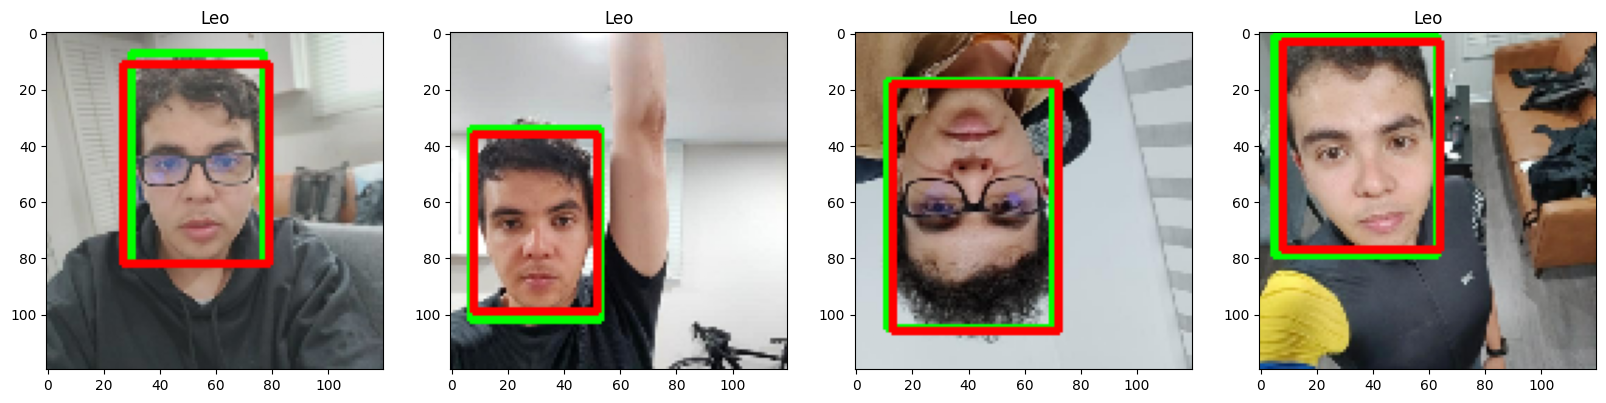

In [392]:
# drawing results

fig, ax = plt.subplots(ncols=8, figsize=(20,20))

for idx in range(8):
    className = ""
    sample_image = test_sample[0][idx].copy()

    classNumber = np.argmax(yhat[0][idx])

    if yhat[0][idx][classNumber] > 0.9:
       sample_coord = yhat[1][idx]
       actual_coord = test_sample[1][1][idx]

       if classNumber == 0:
          className = "Eduardo"
       elif classNumber == 1:
            className = "Leo"

       cv2.rectangle(sample_image,
                     tuple(np.multiply(actual_coord[:2], [120,120]).astype(int)),
                     tuple(np.multiply(actual_coord[2:], [120,120]).astype(int)),
                     (0,255,0), 2)
                     
       cv2.rectangle(sample_image,
                     tuple(np.multiply(sample_coord[:2], [120,120]).astype(int)),
                     tuple(np.multiply(sample_coord[2:], [120,120]).astype(int)),
                     (255,0,0), 2)
                      
    ax[idx].set_title(className)
    ax[idx].imshow(sample_image)

In [398]:
# Intersection-Over-Union is a common evaluation metric for semantic image segmentation.
# Semantic segmentation is a deep learning algorithm that associates a label or category with every pixel in an image.
# It is used to recognize a collection of pixels that form distinct categories.

# IoU = Area of overlap / Area of Union

def Intersection_Over_Union(boxA, boxB):

	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
		
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	
	# compute the area of both the prediction and ground-truth rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	
	# return the intersection over union value
	return iou

In [399]:
# defining iterator for test dataset
test_data = test.as_numpy_iterator()

In [400]:
total_acc   = 0
total_iou   = 0
total_iou_c = 0
batch_iou   = 0
batch_iou_c = 0
total_batch = 0

for x in range (1, 501):
    test_sample = test_data.next()
    
    # Making predictions on Test dataset
    yhat = facetracker.predict(test_sample[0])
    
    # Classification Accuracy
    acc = SparseCategoricalAccuracy()
    acc.update_state(y_true        = test_sample[1][0],
                     y_pred        = yhat[0],
                     sample_weight = None)
    
    total_acc += acc.result().numpy()

    # Intersection Over Union
    batch_iou_c = 0
    batch_iou   = 0
    
    for i in range(0, 8):
        #if (np.argmax(yhat[0][i]) == test_sample[1][0][i]):
        batch_iou_c += 1
        total_iou_c += 1
        batch_iou += Intersection_Over_Union(test_sample[1][1][i], yhat[1][i])
        total_iou += Intersection_Over_Union(test_sample[1][1][i], yhat[1][i])
        
    total_batch += 8
    batch_iou = batch_iou / batch_iou_c
    
    print ("Test sample -->", x,
           "- Processed images -->", total_batch,
           "- Batch Accuracy   -->", acc.result().numpy(),
           "- Batch IoU        -->", batch_iou)

# getting and showing results
total_acc = total_acc / 500 * 100
total_iou = total_iou / total_iou_c * 100

print ()
print ("/******************************************/")
print (f"Total Classification Accuracy : {total_acc:.2f}")
print (f"Total Intersection Over Union : {total_iou:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Test sample --> 1 - Processed images --> 8 - Batch Accuracy   --> 1.0 - Batch IoU        --> 0.9718118794201621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Test sample --> 2 - Processed images --> 16 - Batch Accuracy   --> 1.0 - Batch IoU        --> 0.9716280674212224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Test sample --> 3 - Processed images --> 24 - Batch Accuracy   --> 1.0 - Batch IoU        --> 0.966460071129992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Test sample --> 4 - Processed images --> 32 - Batch Accuracy   --> 1.0 - Batch IoU        --> 0.9757070931284326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Test sample --> 5 - Processed images --> 40 - Batch Accuracy   --> 1.0 - Batch IoU        --> 0.9731419540448166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Test sample --> 6 - Processed images --> 48 - Batch Accuracy   --> 1.0 - Batch IoU        --> 0.9781473133979538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Test sample --> 7 - Processed images --> 56 - Batch